In [1]:
# Adversarial Neural Cryptography - https://arxiv.org/pdf/1610.06918.pdf

# We are now trying part 2 of the paper - Selective hiding

In [3]:
# Necessary imports
import torch
import random

import numpy as np
from torch import nn

import matplotlib.pyplot as plt

/home/radheshyam/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define the length of the key and the message
# pln_txt_len = sec_key_len = cip_txt_len = 16
pln_txt_len = 24 #(8*3)
sec_key_len = 8
cip_txt_len = 8

In [5]:
# The input for this is a tuple of 4 values: <A,B,C,D>

#  Input to Alice: <A,B,C>, secretKey
# Output from Alice: D_public. 
# (Alice should predict D_public (D_preserving) from A,B,C while also making it decorrelated to C.)

#  Input to Bob: D_public, secretKey
# Output from Bob: D_Actual

#  Input to Eve: D_public
# Output from Eve: C (But shouldnt be able to get it)

# Lets take length of A, B, C and D as 4 each. And Secret key to be 8 bits long.

In [6]:
def GenerateInputs(batchSize):

    # For now we will use one correlation matrix for all the inputs. Later on lets test with different correlation matrices for each input.
    # Specify the pairwise correlations between A, B, C, and D


    # Trying out with vectors with 0 or 1 values.

    corr_matrix = np.array([[1.0, 0.5, 0.5, 0.5],
                            [0.5, 1.0, 0.5, 0.5],
                            [0.5, 0.5, 1.0, 0.5],
                            [0.5, 0.5, 0.5, 1.0]])

    # Compute the Cholesky decomposition of the correlation matrix
    L = np.linalg.cholesky(corr_matrix)

    InpData = []
    RealD = []
    RealC = []
    SecretKeys = []

    for i in range(batchSize):
        # Generate vectors of 4 normally distributed floating-point values
        a = np.random.randint(2, size=4)
        b = np.random.randint(2, size=4)
        c = np.random.randint(2, size=4)
        d = np.random.randint(2, size=4)
        secKey = np.random.randint(2, size=8)

        # Multiply the vectors by the lower triangular matrix L to generate A, B, C, and D
        A = np.dot(L, a)
        B = np.dot(L, b)
        C = np.dot(L, c)
        D = np.dot(L, d)

        # Increasing the length of the vectors to 8
        A = np.concatenate((A, np.dot(L,np.random.randint(2, size=4))))
        B = np.concatenate((B, np.dot(L,np.random.randint(2, size=4))))
        C = np.concatenate((C, np.dot(L,np.random.randint(2, size=4))))
        D = np.concatenate((D, np.dot(L,np.random.randint(2, size=4))))

        InpData.append(np.concatenate((A,B,C)))
        RealD.append(D)
        RealC.append(C)
        SecretKeys.append(secKey)

    InpData = torch.tensor(InpData, dtype=torch.float)
    RealD = torch.tensor(RealD, dtype=torch.float)
    SecretKeys = torch.tensor(SecretKeys, dtype=torch.float)
    RealC = torch.tensor(RealC, dtype=torch.float)

    return InpData, RealC, RealD, SecretKeys


In [9]:
InpData,RealC, RealD, SecretKeys = GenerateInputs(3)
print(InpData.shape)
print(RealD.shape)
print(SecretKeys.shape)
# print(InpData)

torch.Size([3, 24])
torch.Size([3, 8])
torch.Size([3, 8])


In [10]:
# Alice's network

# The inputs are no longer -1 and 1. We are having random inputs
class Alice_Net(nn.Module):
    # original dimension: 16, 16, 16
    # Modified Dimensions: 24, 8, 8
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len):
        super(Alice_Net, self).__init__()
        self.input_size  = plain_text_len + secret_key_len
        self.output_size = cipher_text_len
        
        self.OldSize = 32

        self.W = nn.Sequential(
            nn.Linear(self.input_size, self.OldSize),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Linear(16, cip_txt_len),
            nn.Sigmoid(),      
            # commented sigmoid as we are having random integer values for D.

            # Will have to check the dimensions of the output.
            # Since we are reusing the same NN, to change size, adding a final MLP to bring from 16 to 4.
        )
        
    def forward(self, plain_text, secret_key):
        x = torch.cat((plain_text, secret_key), axis=-1)
        x = torch.unsqueeze(x, 1)
        
        x = self.W(x)

        # print("After 1st MLP:")
        # print(x.shape)

        x = self.C(x)

        # what does this do? Since we have one one channel, resizes.
        x = x.view(-1, self.output_size)
        return x
    
    def encrypt(self, plain_text, secret_key):
        D_Public = self.forward(plain_text, secret_key)

        return D_Public
        # what does this do????
        # return torch.as_tensor((encrypted_text - 0.5) > 0, dtype=torch.float32)

In [11]:
# # testX = torch.cat((InpData, SecretKeys), axis=-1)
# # print(testX.shape)
# # print(testX)

# # textX = torch.unsqueeze(testX, 1)
# # print(textX.shape)
# # print(textX)

# print("InpData:")
# print(InpData.shape)
# # print(InpData)

# print("SecretKeys:")
# print(SecretKeys.shape)
# # print(SecretKeys)

# testInstance = Alice_Net(pln_txt_len, sec_key_len, cip_txt_len)
# testX = testInstance.forward(InpData, SecretKeys)
# print(testX.shape)
# # print(testX)

In [12]:
# Bob's network

class Bob_Net(nn.Module):
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len):
        super(Bob_Net, self).__init__()
        self.input_size  = cipher_text_len + secret_key_len
        self.output_size = cipher_text_len
        
        self.OldSize = 32

        self.W = nn.Sequential(
            nn.Linear(self.input_size, self.OldSize),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Linear(16, cip_txt_len),
            nn.Sigmoid(),      
        )
        
    def forward(self, cipher_text, secret_key):
        x = torch.cat((cipher_text, secret_key), axis=-1)
        x = torch.unsqueeze(x, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = x.view(-1, self.output_size)
        return x
    
    def decrypt(self, cipher_text, secret_key):
        D_Bob = self.forward(cipher_text, secret_key)
        return D_Bob
        # return torch.as_tensor((decrypted_text - 0.5) > 0, dtype=torch.float32)

In [18]:
# Eve's network

class Eve_Net(nn.Module):
    def __init__(self, plain_text_len, cipher_text_len):
        super(Eve_Net, self).__init__()
        self.input_size  = cipher_text_len
        self.output_size = cip_txt_len
        
        self.OldSize = 32

        self.W = nn.Sequential(
            nn.Linear(self.input_size, self.OldSize),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Linear(16, cip_txt_len),
            nn.Sigmoid(),
        )
        
    def forward(self, cipher_text):
        x = torch.unsqueeze(cipher_text, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = x.view(-1, self.output_size)
        return x
    
    def eavesdrop(self, cipher_text):
        eavesdrop_C = self.forward(cipher_text)
        return eavesdrop_C

In [14]:
# Define the device

# USE_CUDA = torch.cuda.is_available()
# device = torch.device("cuda" if USE_CUDA else "cpu")
device = torch.device("cpu")
# print(torch.cuda.get_device_name(torch.cuda.current_device()))

In [15]:
# Instantiate the models

Alice = Alice_Net(pln_txt_len, sec_key_len, cip_txt_len).to(device)
Bob   = Bob_Net(pln_txt_len, sec_key_len, cip_txt_len).to(device)
Eve   = Eve_Net(pln_txt_len, cip_txt_len).to(device)

print("All models instantiated successfully !!!")

All models instantiated successfully !!!


In [16]:
# Hyperparameters
n_epochs   = 3
eve_edge   = 2

train_size = 2 ** 16
batch_size = 256

# Define the optimizers
lr = 0.008

optim_Alice_Bob = torch.optim.Adam(list(Alice.parameters()) + list(Bob.parameters()), lr=lr)
optim_Eve   = torch.optim.Adam(Eve.parameters(), lr=lr)

optimizers  = [optim_Alice_Bob, optim_Eve]

In [19]:
# Custom Loss functions
class AliceBobLoss(nn.Module):
    def __init__(self):
        super(AliceBobLoss, self).__init__()
    
    def forward(self, RealD, D_public, D_Bob, alice_eve_loss):
        # loss = torch.mean(torch.sum(torch.abs(torch.sub(plain_text, decrypted_text)), 1))
        loss = torch.mean(torch.sum(torch.abs(torch.sub(D_Bob, RealD)), 1))
        loss += torch.mean(torch.sum(torch.abs(torch.sub(D_public, RealD)), 1))
        loss += ((sec_key_len/2 - alice_eve_loss.item())**2)/((sec_key_len/2)**2)
        # loss += ((cip_txt_len/2 - alice_eve_loss.item())**2)/((cip_txt_len/2)**2)
        # loss += (np.log(alice_eve_loss.item() + 1))
        # loss += np.exp(alice_eve_loss.item())-1
        return loss
    
class AliceEveLoss(nn.Module):
    def __init__(self):
        super(AliceEveLoss, self).__init__()
    
    def forward(self, RealC, predictedC):
        # return torch.mean(torch.sum(torch.abs(torch.sub(plain_text, eavesdrop_text)), 1))
        return torch.mean(torch.sum(torch.abs(torch.sub(RealC, predictedC)), 1))

    
criterion_AliceBob = AliceBobLoss()
criterion_AliceEve = AliceEveLoss()

criterions = [criterion_AliceBob, criterion_AliceEve]

def hamming_distance(x, y):
    return torch.sum(torch.abs(x - y))

In [20]:

# Train the networks
# Eve is trained eve_edge times for every training of Alice and Bob

def train(Alice, Bob, Eve, criterions, optimizers, train_size=10000, eve_edge=2, n_epochs=100, batch_size=256):
    print("Training started ...")
    
    # Initialize the losses
    n_batches = train_size // batch_size
    alice_bob_dist = []
    alice_eve_dist = []
    
    for epoch in range(n_epochs):
        bob_dist, eve_dist = np.zeros(n_batches), np.zeros(n_batches)
        alice_eve_loss = torch.tensor(cip_txt_len * 0.5, requires_grad=True, device=device)

        for batch in range(n_batches):            
            # plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
            InpData, RealC, RealD, SecretKeys = GenerateInputs(batch_size)
            InpData, RealC, RealD, SecretKeys = InpData.to(device), RealC.to(device), RealD.to(device), SecretKeys.to(device)
            # plain_text, secret_key = plain_text.to(device), secret_key.to(device)
        
            # Train Alice and Bob
            optimizers[0].zero_grad()
        
            D_public = Alice(InpData, SecretKeys)
            D_Bob = Bob(D_public, SecretKeys)

            # Expectation of the loss
            bob_loss = criterions[0](RealD, D_public, D_Bob, criterions[1](RealC, Eve(D_public)))
            bob_dist[batch] = bob_loss.item()

            bob_loss.backward()
            optimizers[0].step()

            # Train Eve
            for _ in range(eve_edge):
                InpData, RealC, RealD, SecretKeys = GenerateInputs(batch_size)
                InpData, RealC, RealD, SecretKeys = InpData.to(device), RealC.to(device), RealD.to(device), SecretKeys.to(device)
            
                optimizers[1].zero_grad()
                
                # Detach the encrypted text from the graph to prevent backpropagation
                D_public = Alice(InpData, SecretKeys).detach()
                predicetdC = Eve(D_public)
            
                # Expectation of the loss    
                eve_loss = criterions[1](RealC, predicetdC)     
                eve_dist[batch] += eve_loss.item()                 
                if alice_eve_loss.item() > eve_loss.item():
                    alice_eve_loss = torch.tensor(eve_loss.item(), requires_grad=True, device=device)
                
                alice_eve_loss.backward(retain_graph=True)
                optimizers[1].step()
            eve_dist[batch] /= eve_edge
            
            # # Validation for Alice, Bob and Eve
            # with torch.no_grad():
            #     plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 128)
            #     plain_text, secret_key = plain_text.to(device), secret_key.to(device)
            
            #     encrypted_text = Alice.encrypt(plain_text, secret_key)
            #     decrypted_text = Bob.decrypt(encrypted_text, secret_key)
            #     eavesdrop_text = Eve.eavesdrop(encrypted_text)
            
            #     ab = hamming_distance(decrypted_text, plain_text).cpu().numpy() / 128 * 1.0
            #     ae = hamming_distance(eavesdrop_text, plain_text).cpu().numpy() / 128 * 1.0
                
            #     alice_bob_dist[epoch * n_batches + batch] = bob_dist[batch] = ab
            #     alice_eve_dist[epoch * n_batches + batch] = eve_dist[batch] = ae
                
            print("\rEpoch: {}/{} | Batch: {}/{} | Bob: {:.4f} | Eve: {:.4f}".format(epoch+1, n_epochs, batch+1, n_batches, bob_dist[batch], eve_dist[batch]), end="", flush=True)
        alice_bob_dist.append(bob_dist)
        alice_eve_dist.append(eve_dist)
        print("\rEpoch: {}/{} | Average Distance  Bob (from RealD): {} , Eve (from RealC): {}".format(epoch+1, n_epochs, np.round(np.mean(alice_bob_dist[epoch]), 4), np.round(np.mean(alice_eve_dist[epoch]), 4)), end='\n', flush=True)
    
    print("\rTraining completed !!!")
    return alice_bob_dist, alice_eve_dist
    
# Set the models to train mode
Alice.train()
Bob.train()
Eve.train()

ab_dist, ae_dist = train(Alice, Bob, Eve, criterions, optimizers, train_size, eve_edge, n_epochs, batch_size)

Training started ...
Epoch: 1/3 | Average Distance  Bob (from RealD): 7.2608 , Eve (from RealC): 5.7172
Epoch: 2/3 | Average Distance  Bob (from RealD): 7.2361 , Eve (from RealC): 5.7332
Epoch: 3/3 | Average Distance  Bob (from RealD): 7.2369 , Eve (from RealC): 5.7312
Training completed !!!


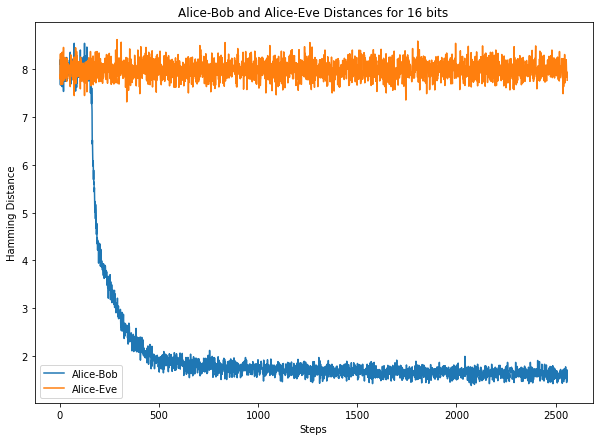

In [104]:
# Plot the results
plt.figure(figsize=(10, 7))
plt.title("Alice-Bob and Alice-Eve Distances for {} bits".format(sec_key_len))

steps = np.arange(ab_dist.shape[0])
plt.plot(steps, ab_dist, label="Alice-Bob")
plt.plot(steps, ae_dist, label="Alice-Eve")
plt.ylabel("Hamming Distance")
plt.xlabel("Steps")

plt.legend()
plt.show()

In [105]:
# Set the models to evaluation mode
Alice.eval()
Bob.eval()
Eve.eval()

# Test the networks
plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 1)
plain_text, secret_key = plain_text.to(device), secret_key.to(device)

print("Plain text: ", plain_text.cpu().squeeze().numpy())

encrypted_text = Alice.encrypt(plain_text, secret_key)
print("Encrypted text: ", encrypted_text.detach().cpu().squeeze().numpy())
      
decrypted_text = Bob.decrypt(encrypted_text, secret_key)
print("Bob's decrypted text: {}, Distance: {:.4f}".format(decrypted_text.detach().cpu().squeeze().numpy(), hamming_distance(decrypted_text, plain_text).item()))

eavesdrop_text = Eve.eavesdrop(encrypted_text)
print("Eve's eavesdrop text: {}, Distance: {:.4f}".format(eavesdrop_text.detach().cpu().squeeze().numpy(), hamming_distance(eavesdrop_text, plain_text).item()))

Plain text:  [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
Encrypted text:  [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0.]
Bob's decrypted text: [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], Distance: 3.0000
Eve's eavesdrop text: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Distance: 3.0000
